In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import scipy as sp
import skimage
import os

from skimage.color import rgb2gray
from scipy.signal import convolve2d
from scipy.ndimage import rank_filter
from scipy.stats import norm
from PIL import Image
from utils import dist2, gen_dgauss, find_sift, harris
from utils import eucl_dist

In [3]:
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

In [4]:
print(os.getcwd()+'/uttower_left.jpeg')

/home/xiaobao/Python_Venvs/cv_venv/EME_174/Image_Stitching/uttower_left.jpeg


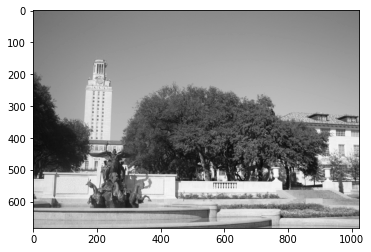

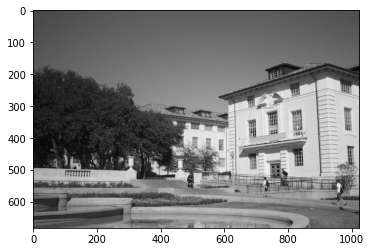

In [5]:
towerLeft = cv.imread(os.getcwd()+'/uttower_left.jpeg', 0)
towerRight = cv.imread(os.getcwd()+'/uttower_right.jpeg', 0)
towerLeft = cv.normalize(towerLeft.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
towerRight = cv.normalize(towerRight.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)

plt.figure()
plt.imshow(towerLeft, cmap=plt.get_cmap('gray'))
plt.figure()
plt.imshow(towerRight, cmap=plt.get_cmap('gray'))

### Detect Feature Points via Harris Detector

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]] [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]
<class 'numpy.ndarray'>


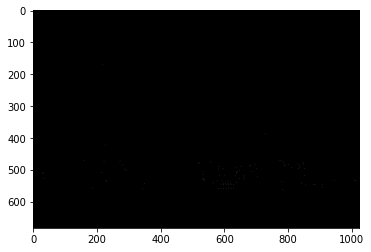

In [6]:
tower_harris_L, L_rows, L_cols = harris(towerLeft, sigma=1.0, thresh=0.3, radius=2.0)
print(type(tower_harris_L))
L_pts = np.vstack((L_rows, L_cols))
L_pts = L_pts.T
plt.imshow(tower_harris_L, cmap=plt.get_cmap('gray'))

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]] [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]
<class 'numpy.ndarray'>


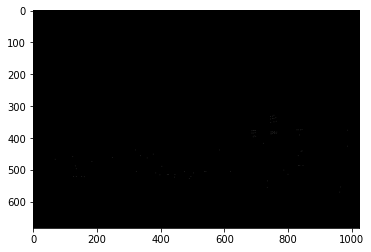

In [7]:
tower_harris_R, r_rows, r_cols = harris(towerRight, sigma=1.0, thresh=0.3, radius=2.0)
print(type(tower_harris_R))
R_pts = np.vstack((r_rows, r_cols))
R_pts = R_pts.T
plt.imshow(tower_harris_R, cmap=plt.get_cmap('gray'))

### Compute Euclidian Distances between correspondance points

In [17]:
_dist1 = np.array([[2,2], [1,1]])
_dist2 = np.array([[4,4], [5,5]])

print(np.sqrt(dist2(_dist1, _dist2)))

# foo_1 = np.array([[2, 2]])
# foo_2 = np.array([[4, 4]])
# print(eucl_dist(_dist1, _dist2))

[[2.82842712 4.24264069]
 [4.24264069 5.65685425]]


In [20]:
dists = np.sqrt(dist2(L_pts, R_pts))
print(dists.shape)
print(dists[:3][:3])

(82, 104)
[[558.80229062  64.47480128 535.3176627  143.19916201 610.73725938
  143.26548782 551.14426424 503.05069327 247.40654801 149.83324064
  276.56825559 174.59095051 281.01601378 170.39366185 178.53010951
  164.91512969 158.685223   161.40012392 499.01102192 174.4706279
  177.09884246 176.66352198 162.59458786 190.28662591 237.05906437
  201.22872558 182.91254741 174.24408168 183.48024417 231.31147831
  176.46529404 193.99226789 497.57913943 241.84705911 492.97870137
  204.79257799 209.69501663 188.67962264 284.54876559 744.8288394
  213.84573879 568.26138352 745.5554976  215.82400237 288.85463472
  254.13579047 243.02263269 211.98348992 225.25763028 212.42645786
  199.62464778 216.04166265 332.02409551 295.97972904 226.01991063
  747.958555   779.10782309 300.21658848 297.25746416 222.31958978
  564.17373211 278.0953074  328.12345238 298.51968109 325.62862282
  337.41517453 272.24988522 262.06869328 251.91466809 563.40482781
  210.48990475 284.01584463 242.14252002 265.8006772  

In [10]:
def pt_matches(dists, thresh=None):
    """
    Retrieves putative matches of interest that are under some max distance
    Parameters
    ----------
    dists: numpy.ndarray
        Data of shape `(ndata, dimx)`
    thresh: float
        Normalized value from [0,1]
    Returns
    ----------
    matches: numpy.ndarray
        Indices of promising matches and their distances
    """
    matches = []
    # dist_norms = [float(i)/max(dists) for i in dists]
    dist_norms = dists / np.sqrt(np.sum(dists ** 2))
    # print(dist_norms)
    print(dist_norms.shape)

    for n in range(len(dist_norms)):
        # val = dist_norms[n]
        # print(n, val)
        # if val < thresh:
            # matches.append([n, dists[n]])

    # return np.asarray(matches, dtype=np.float32)

# print(pt_matches(dists, 0.5))

(82, 104)
0 [0.01636972 0.00188874 0.01568176 0.00419492 0.01789112 0.00419686
 0.01614539 0.01473652 0.0072476  0.00438926 0.00810187 0.00511452
 0.00823217 0.00499156 0.00522991 0.00483107 0.00464857 0.0047281
 0.01461818 0.005111   0.00518799 0.00517523 0.00476309 0.00557431
 0.00694448 0.00589485 0.0053583  0.00510436 0.00537493 0.00677611
 0.00516943 0.00568287 0.01457623 0.00708474 0.01444147 0.00599926
 0.00614287 0.00552724 0.00833566 0.02181924 0.00626446 0.01664682
 0.02184053 0.00632241 0.00846179 0.00744473 0.00711918 0.00620991
 0.00659876 0.00622288 0.00584786 0.00632879 0.00972641 0.00867052
 0.0066211  0.02191092 0.02282342 0.00879464 0.00870795 0.0065127
 0.01652708 0.00814661 0.00961215 0.00874493 0.00953906 0.00988434
 0.00797537 0.00767712 0.00737966 0.01650455 0.00616615 0.00832005
 0.0070934  0.00778645 0.00764856 0.00751546 0.00738739 0.00672909
 0.01344452 0.00798032 0.00786338 0.00772776 0.00759694 0.0074712
 0.00735077 0.00732152 0.00739529 0.00774445 0.007052

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
nums = [1, 2, 3, 4, 5]
tmp = 4

nums = nums[tmp > 1 :]
print(nums)

[2, 3, 4, 5]
